# Implementation of Monte Carlo Simulation for model with fully open ICVs
Ashish Bhattarai and Bernt Lie,
University of South-Eastern Norway,
Porsgrunn, May 2021

Packages

In [ ]:
using Plots
addprocs()
@everywhere using DifferentialEquations
using Distributions
using Distributed
using LaTeXStrings
using LinearAlgebra
pyplot();
using SparseArrays
using StaticArrays
using JLD    #used to store the data

In [ ]:
LW1 = 2.5;
LCoil = :darkred;
LCwater = :blue;
# Plotting befor and after together
figpath = "D:/USN/Asis/MS_Thesis/USN-MSc-Lyx-Template/fig/"

In [3]:
################Constants########
g = 9.81;   #acceleration due to gravity
d2s = 86400.0;  #Factor to convert day to seconds

#Reservoir dimension
R = 200;  #in meters
L = 1200;  #in meters

#curve fitting parameters obtained from saturation and permeability data
fit1 = 3.4830677845851046;
fit2 = 0.00043971820694883656;
fit3 = 3.5326302833873475;
fit4 = 2.6282606178861068;

###########Grid size#############
m = 20; #number of grids along R
n = 20; #number of grids along L
Delr = R/m;   #step length along R
Dell = L/n;   #step length along L

##########Fluid properties########
rhoo = 950.0;  #Density of oil
rhow = 1050.0; #Density of water
uo = 100e-3;    #Oil viscosity
uw = 1e-3;   #Water viscosity

#######Rock properties##########
K_R = 1.0*1.4803849e-12;   #Absolue permability of rock along r
K_L = 1.0*1.4803849e-12;   #Absolue permability of rock along l
K_eff = sqrt(K_R*K_L);  #Effective permeability
alpha = 20*pi/180;      #Inclination angle of a wedge shaped reservoir
beta = 25*pi/180;    #arch angle of a wedge shaped reservoir
theta = alpha + beta/2;
phi = 0.27;   #rock porosity

##########Aquifier properties##########
Kwa = 1.0;    #Relative permeability of aquifer
P_a = 115e5;  # Aquifier pressure

##########Well properties#############
rw = 0.124/2.0;  #Well radius
re = 0.5*Delr;    #equivalent radius
Lw = 1200;   #Well length
Del_Lp = Dell;   #pipe step length
Nv = n;  #Number of valves
Qtot = 0.00925926;    #total specified flow rate
Ar = pi*0.003217^2/4.0;  #Orifice are

##########Array allocation for pentadiagonal matrix and other matrices##########
B_sparse = sparse(zeros(Float64, m*n,m*n));  #Column vector of size m*n, used sparse matrix to speed up the simulation
A_sparse = sparse(zeros(Float64, m*n,m*n));  #pentadiagonal matrix of dimension m*n x m*n, used sparse matrix to speed up the simulation
v = zeros(Float64, m*n);       #column vector of size m*n
P = zeros(Float64, m*n);       #matrix of dimension m x n for pressure at each block

############Arrays to store fluid flow rates,combined density and well pressure#########
qmix = zeros(Float64,n,1);
q_w = zeros(Float64,n,1);  #Water flow rate
prw = zeros(Float64,n,1);     #initialize for well pressure
rho_mix = zeros(Float64,n,1);

# Function to calculate permeability and to update water saturation

In [ ]:
function UpdatePerm(Sat)
    Perm_w = zeros(Float64, m,n);
    Perm_o = zeros(Float64, m,n);
    for i = 1:1:m
        for j = 1:1:n
            if Sat[i,j] >= 1.0
                Sat[i,j] = 1.0;
                Perm_w[i,j] = 1.0;
                Perm_o[i,j] = 0.0;
            elseif Sat[i,j] > 0.0;
                Perm_w[i,j] = Sat[i,j]^fit1 + fit2;
                Perm_o[i,j] = (1.0 -Sat[i,j])^fit3 * (1.0 -Sat[i,j]^fit4);
            else
                Sat[i,j] = 0.0;
                Perm_w[i,j] = 0.0;
                Perm_o[i,j] = 1.0;
            end
        end
    end
    return [Sat,Perm_w,Perm_o];
end

# Function to calcuate fluid flow distribution at the well

In [ ]:
function Borehole(prw,Qtot,Ax,rhomix)
    Area = zeros(Nv,1);
    Area[1:Nv] .= Ax;
    Q = zeros(Nv+1,1);
    pbh = zeros(Nv+1,1);
    pbh_limit = 85e5;
    Q[1] = Qtot
    rp = 0.124;
    Cv = 1.0;
    Cu = 1.0;
    q = zeros(Nv,1);
    fr = 0.00001;
    a = Qtot/Nv;
    b = -a^2 *(Cu*mean(rhomix))/(Cv^2*(mean(Area))^2) + mean(prw[1:Nv]);
    pbh[1] = b - fr*mean(rhomix)*8*Del_Lp/(pi^2*(2*rp)^5)*Qtot;
    if pbh[1] > pbh_limit
        pbh[1] = pbh_limit;
    end
    for i = 1:Nv
        pbh[i+1]=pbh[i]+fr*rhomix[i]*8*Del_Lp/(pi^2*(2*rp)^5)*Q[i];
        if (prw[i]-pbh[i+1])<0.0
            break;
        end
        q[i]=sqrt((prw[i]-pbh[i+1])*Cv^2*Area[i]^2/(Cu*rhomix[i]));
        Q[i+1] = Q[i] - q[i];
        if Q[i+1] <=0.0
            break;
        end
    end
    return [q,pbh[1]];
end

# Function to calculate pressure equation

In [ ]:
function PressureCalc(Krw,Kro,qmix)
    f = zeros(Float64, m*n);       #column vector of size m*n
    #For blocks at i = 1 and j = 1
    i = 1;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = R;
    ro = R - i*Delr;
    T_a = (Kwa/uw)*K_eff;
    T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_a = (Kwa*rhow/uw)*K_eff;
    E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
    A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*T_i1j;
    A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
    A_sparse[z,z+n] = (1/(r*Delr^2))*ro*T_ij;
    f[1] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*( E_ij*ro - E_a*ri)*g*sin(theta);
    #For blocks at i = 1 and j = 2:n-1
    i = 1;
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-1] = (1/(Dell^2))*T_ij;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*(T_ij + T_i1j);
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        A_sparse[z,z+n] = (1/(r * Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*(E_ij*ro - E_a*ri)*g*sin(theta);
    end
    #For blocks at i = 1 and j = n
    i = 1;
    j = n;
    z = n*(i-1)+j;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
    A_sparse[z,z-1] = (1/Dell^2)*T_ij;
    A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*T_ij;
    A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
    f[z] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*(E_ij*ro - E_a*ri)*g*sin(theta);
    
    #For blocks at i = 2(m-1) and j = 2:(n-1)
    for i = 2:1:m-1
        r = R + (0.5-i)*Delr;
        ri = r + 0.5*Delr;
        ro = r - 0.5*Delr;
        for j = 2:1:n-1
            z = n*(i-1)+j;
            T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
            T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
            T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
            E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
            E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
            A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
            A_sparse[z,z-1] = (1/Dell^2)*T_ij;
            A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*(T_i1j+T_ij);
            A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
            A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
            f[z] = -(1/(r*Delr))*( E_ij*ro - E_ij1*ri)*g*sin(theta);
        end
        #For blocks at j = 1 and i = 2:m-1
        j = 1;
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*T_i1j;
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr))*(E_ij*ro - E_ij1*ri)*g*sin(theta);
        #For blocks at j = n and i = 2:m-1
        j = n;
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
        A_sparse[z,z-1] = (1/Dell^2)*T_ij;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*T_ij;
        A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr))*(E_ij*ro - E_ij1*ri)*g*sin(theta);
    end
    
    #For blocks at i = m and j = 1
    i = m;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = r + 0.5*Delr;
    ro = r - 0.5*Delr;
    T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
    T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
    E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
    A_sparse[z,z-n] = (1/(r*Delr^2))*ri*T_ij1;
    A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*T_i1j;
    A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
    f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    #For blocks at i = m and j = n
    j = n;
    z = n*(i-1)+j;
    T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
    A_sparse[z,z-n] = (1/(r*Delr^2))*(ri*T_ij1);
    A_sparse[z,z-1] = (1/Dell^2)*T_ij ;
    A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*T_ij; 
    f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    #For blocks at i = m and j = 2:n-1
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r * Delr^2))*T_ij1*ri;
        A_sparse[z,z-1] = (1/Dell^2)*T_ij ;
        A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*(T_ij + T_i1j);
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    end
    #Solving for the pentadiagonal matrix
    p = A_sparse\f;
    return p;
end 

# ODE function

In [5]:
function reservoir(du,Sw,p,t)
    phi,K_R,K_L,Kwa,alpha,beta = p
    K_eff = sqrt(K_R*K_L);  
    Sw,Krw,Kro = UpdatePerm(Sw);  #call function to calculate permeabilities and updating water saturation
    P = PressureCalc(Krw,Kro,qmix);  #call function to calculate pressure
    for j=1:n
        To=(Kro[m,j]*K_eff/uo);
        Tw=(Krw[m,j]*K_eff/uw);
        prw[j]=P[n*(m-1)+j]-((-qmix[j]/(2*pi*Dell/log(re/rw))+(To*rhoo+Tw*rhow)*g*sin(theta)*(re-rw))/(To+Tw));  #calculation of well pressure
        rho_mix[j] = (To*rhoo+Tw*rhow)/(To+Tw);  #calculation of mixed fluid density
    end
    qmix[1:Nv] = Borehole(prw,Qtot,Ar,rho_mix)[1];  #call function to calculate fluid flow through different ICVs
    for j = 1:Nv
        q_w[j] = ((Krw[m,j]/uw)/(Kro[m,j]/uo+Krw[m,j]/uw))*qmix[j];   #Water flow
    end
    # Saturation calculation For blocks at i = 1 and j = 1
    i = 1;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = R;
    ro = R - i*Delr;
    T_a = (Kwa/uw)*K_eff;
    T_ji1 = (Krw[i,j+1]/uw)*K_eff;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_a = (Kwa*rhow/uw)*K_eff;
    E_ji = (Krw[i,j]*rhow/uw)*K_eff;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji1); #Little different than the zhangs code
    B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
    B_sparse[z,z+n] = 1/(r*Delr^2)*ro*T_ji;
    v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*( E_ji*ro - E_a*ri)*g*sin(theta);
    #Saturation calculation For blocks at i = 1 and j = 2:n-1
    i = 1;
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji + T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
        B_sparse[z,z+n] = 1/(r * Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*( E_ji*ro - E_a*ri)*g*sin(theta);
    end
    #For blocks at i = 1 and j = n
    i = 1;
    j = n;
    z = n*(i-1)+j;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_ji = (Krw[i,j]*rhow/uw)*K_eff;
    B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji);
    B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
    v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*(E_ji*ro - E_a*ri)*g*sin(theta);
    
    #For blocks at i = 2:m-1 and j = 1:n
    for i = 2:1:m-1
        r = R + (0.5-i)*Delr;
        ri = r + 0.5*Delr;
        ro = r - 0.5*Delr;
        for j = 2:1:n-1
            z = n*(i-1)+j;
            T_j1i = (Krw[i-1,j]/uw)*K_eff;
            T_ji1 = (Krw[i,j+1]/uw)*K_eff;
            T_ji = (Krw[i,j]/uw)*K_eff;
            E_ji = (Krw[i,j]*rhow/uw)*K_eff;
            E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
            B_sparse[z,z-n] = 1/(r*Delr^2)*(T_j1i*ri);
            B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
            B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji1+T_ji);
            B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
            B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
            v[z] = -1/(r*Delr)*( E_ji*ro - E_j1i*ri)*g*sin(theta);
        end
        j = 1;
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r*Delr^2)*T_j1i*ri;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
        B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr)*(E_ji*ro - E_j1i*ri)*g*sin(theta);

        j=n;
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r*Delr^2)*T_j1i*ri;
        B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji);
        B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr)*(E_ji*ro - E_j1i*ri)*g*sin(theta);
    end
    
    #For blocks at i = m and j = 1
    i = m;
    j = 1;
    r = R + (0.5-i)*Delr;
    ri = r + 0.5 * Delr;
    ro = r - 0.5 * Delr;
    z = n*(i-1)+j;
    T_j1i = (Krw[i-1,j]/uw)*K_eff;
    T_ji1 = (Krw[i,j+1]/uw)*K_eff;
    E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
    B_sparse[z,z-n] = 1/(r*Delr^2)*(ri*T_j1i)
    B_sparse[z,z] =-1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji1) ;
    B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
    v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri )*g*sin(theta);
    #For blocks at i = m and j = n
    j = n;
    z = n*(i-1)+j;
    T_j1i = (Krw[i-1,j]/uw)*K_eff;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
    B_sparse[z,z-n] = 1/(r*Delr^2)*(ri*T_j1i);
    B_sparse[z,z-1] = 1/(Dell^2)*T_ji ;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji) ;
    v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri )*g*sin(theta);
    #For blocks at i = m and j = 2:n-1
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r * Delr^2)*(T_j1i*ri);
        B_sparse[z,z-1] = 1/(Dell^2)*(T_ji) ;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji + T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*(T_ji1);
        v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri)*g*sin(theta);
    end
    dw = B_sparse*P-v;
    for i = 1:1:m
        du[i,1:n] = (d2s/phi)*dw[n*(i-1)+1:n*i]
    end
end

reservoir (generic function with 1 method)

# Initiating simulation

In [25]:
low_Sw0 = 0.8    #lower limit of water saturation
high_Sw0 = 1.2    #Upper limit of water saturation
low_phi = 0.8     #Lower limit of porosity
high_phi = 1.2    #Upper limit of porosity
low_K = 0.8     #Lower limit of absolute permeability
high_K = 1.2    #Upper limit of absolute permeability

t_stop = 1000;   #Simulation time
Sw0 = [0.15 for x in 1:m, y in 1:n];  #Initial water saturation
p = [phi,K_R,K_L,Kwa,alpha,beta];   #Parameters
tspan = [0.0,t_stop];
prob = ODEProblem(reservoir,Sw0,tspan, p);   #creating ODE problem
@everywhere function prob_func(prob,i,repeat)
    ODEProblem(prob.f,rand(Uniform(low_Sw0, high_Sw0))*Sw0,prob.tspan,
              [phi*rand(Uniform(low_phi, high_phi)),
               K_R*rand(Uniform(low_K,high_K)),K_L*rand(Uniform(low_K,high_K)),
               Kwa,alpha,beta])
end

ensemble_prob = EnsembleProblem(prob,prob_func=prob_func)  #creating ensemble problem

EnsembleProblem with problem ODEProblem

In [26]:
@time begin
sim = solve(ensemble_prob,Tsit5(),num_monte=100);  #Simulating the model
end

1214.785833 seconds (12.68 G allocations: 346.410 GiB, 2.84% gc time, 0.24% compilation time)


┌ Warning: num_monte has been replaced by trajectories
└ @ SciMLBase C:\Users\asisb\.julia\packages\SciMLBase\yh1iq\src\ensemble\basic_ensemble_solve.jl:47


EnsembleSolution Solution of length 100 with uType:
ODESolution{Float64, 3, Vector{Matrix{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{Float64}}}, ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(reservoir), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5, OrdinaryDiffEq.InterpolationData{ODEFunction{true, typeof(reservoir), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Vector{Matrix{Float64}}, Vector{Float64}, Vector{Vector{Matrix{Float64}}}, OrdinaryDiffEq.Tsit5Cache{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, OrdinaryDiffEq.Tsit5ConstantCach

# Calculating and storing required measurmen values

In [27]:
num_monte=100;
Sat_monte = zeros(Float64,m,n,tim,num_monte);
permo_monte = zeros(Float64,m,n,tim,num_monte);
permw_monte = zeros(Float64,m,n,tim,num_monte);
Press_monte = zeros(Float64,m*n,tim,num_monte);
Press_i_monte = zeros(Float64,m,n,tim,num_monte);

prw_monte = zeros(Float64,n,tim,num_monte);
qmix_monte = zeros(Float64,n,tim+1,num_monte);
qo_monte = zeros(Float64,n,tim,num_monte);
qw_monte = zeros(Float64,n,tim,num_monte);

Press_average_monte = zeros(Float64,m,tim,num_monte);
Saturation_average_monte = zeros(Float64,m,tim,num_monte);

summat_qo_monte = zeros(Float64,tim,num_monte);
summat_qw_monte = zeros(Float64,tim,num_monte);
Acc_qo_monte = zeros(Float64,tim+1,num_monte);
Acc_qw_monte = zeros(Float64,tim+1,num_monte);
q_wcut_monte = zeros(Float64,n,tim,num_monte);

rho_mix_monte = zeros(Float64,n,tim,num_monte);
pb_monte = zeros(Float64,tim,num_monte)

for i in 1:num_monte
    for k in 1:t_stop
        Sat_monte[:,:,k,i] = sim[i](1:t_stop)[k];
    end 
end


In [28]:
for k in 1:num_monte
    #Calculating permaebilities
    for i in 1:tim
        @. permo_monte[:,:,i,k] = (1.0 - Sat_monte[:,:,i,k])^fit3 * (1.0 - Sat_monte[:,:,i,k]^fit4);
        @. permw_monte[:,:,i,k] = Sat_monte[:,:,i,k]^fit1 + fit2;
    end
    #Calculating pressure
    for i in 1:tim
        Press_monte[:,i,k] =   PressureCalc(permw_monte[:,:,i,k],permo_monte[:,:,i,k],qmix_monte[:,i,k]);
        @. prw_monte[:,i,k]=Press_monte[(m*n-n+1):(m*n),i,k]-((qmix_monte[:,i,k]/(2*pi*Dell/log(re/rw))+((permo_monte[m,:,i,k]*K_eff/uo)*rhoo+(permw_monte[m,:,i,k]*K_eff/uw)*rhow)*g*sin(theta)*(re-rw))/((permo_monte[m,:,i,k]*K_eff/uo)+(permw_monte[m,:,i,k]*K_eff/uw)));
        @. rho_mix_monte[:,i,k] = ((permo_monte[m,:,i,k]*K_eff/uo)*rhoo+(permw_monte[m,:,i,k]*K_eff/uw)*rhow)/((permo_monte[m,:,i,k]*K_eff/uo)+(permw_monte[m,:,i,k]*K_eff/uw));
        for j = 1:Nv
            q_wcut_monte[j,i,k] = ((permw_monte[m,j,i,k]/uw)/(permo_monte[m,j,i,k]/uo + permw_monte[m,j,i,k]/uw));
        end

        qmix_monte[:,i+1,k],pb_monte[i,k] = Borehole(prw_monte[:,i,k],Qtot,Ar,rho_mix_monte[:,i,k]);

        @. qo_monte[:,i,k] =   (1-((permw_monte[m,:,i,k]/uw)/(permo_monte[m,:,i,k]/uo + permw_monte[m,:,i,k]/uw)))*qmix_monte[:,i+1,k];
        @. qw_monte[:,i,k] = (((permw_monte[m,:,i,k]/uw)/(permo_monte[m,:,i,k]/uo + permw_monte[m,:,i,k]/uw)))*qmix_monte[:,i+1,k]; 
        for j in 1:m
            Press_i_monte[j,:,i,k] = Press_monte[n*(j-1)+1:n*j,i,k]
        end

        for j in 1:m
            Press_average_monte[j,i,k] = mean(Press_i_monte[j,:,i,k]);
        end

        for j in 1:m
            Saturation_average_monte[j,i,k] = mean(Sat_monte[j,:,i,k]);
        end

        summat_qo_monte[i,k] = sum(qo_monte[:,i,k]);
        summat_qw_monte[i,k] = sum(qw_monte[:,i,k]);
        Acc_qo_monte[i+1,k] = Acc_qo_monte[i,k] + summat_qo_monte[i,k]*d2s;
        Acc_qw_monte[i+1,k] = Acc_qw_monte[i,k] + summat_qw_monte[i,k]*d2s;
    end
end

# Plotting results

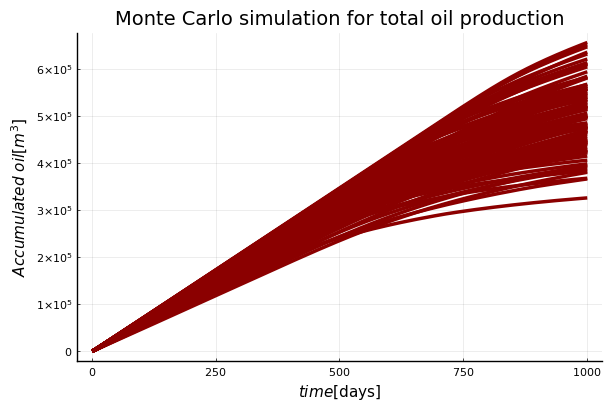

In [51]:
plot(Acc_qo_monte[:,:],lc=LCoil,lw=LW1, legend = false,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ oil[m^3]",title = "Monte Carlo simulation for total oil production")
figfile="AccumulatedoilMonteCarlo_OpenValve_CF.svg"
savefig(figpath*figfile)

In [44]:
findmin(q_wcut_monte[10,1000,:])

(0.486678019748609, 11)

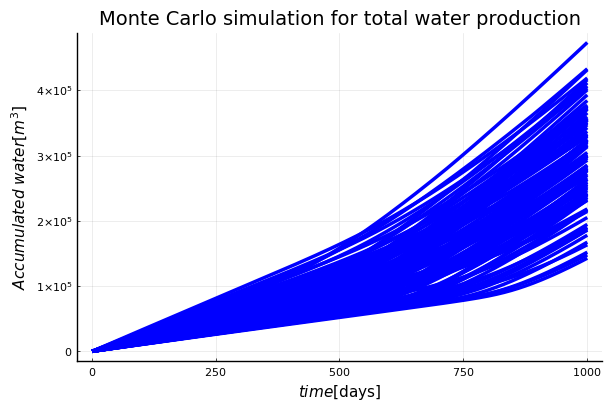

In [52]:
plot(Acc_qw_monte[:,:],lc=LCwater,lw=LW1, legend = false,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ water[m^3]",title = "Monte Carlo simulation for total water production")
figfile="AccumulatedwaterMonteCarlo_OpenValve_CF.svg"
savefig(figpath*figfile)

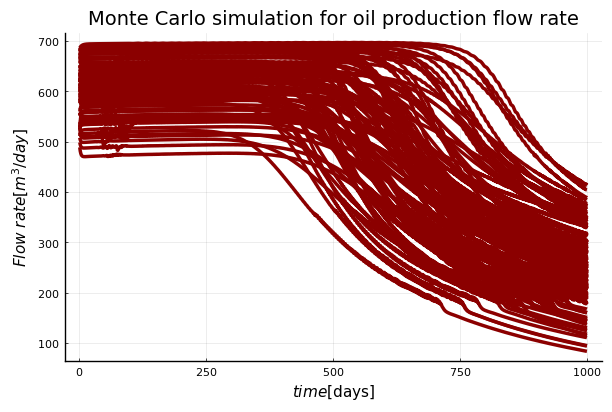

In [128]:
plot(summat_qo_monte[:,:]*3600*24, legend = false,lc=LCoil,
    lw=LW1, label = L"q_\mathrm{o,s,tot}",
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"Flow\ rate[m^3/day]",title = "Monte Carlo simulation for oil production flow rate")
figfile="Flowrates_monte_OpenValve_CF.svg"
savefig(figpath*figfile)

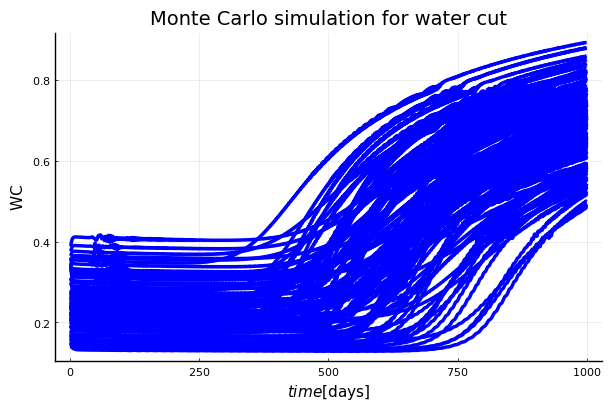

In [56]:
plot(q_wcut_monte[10,:,:],lw=LW1,label = L"n_\ell=10",legend = false,lc=LCwater,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"\mathrm{WC}", title = "Monte Carlo simulation for water cut")
figfile="watercut_monte_OpenValve_CF.svg"
savefig(figpath*figfile)

# Importing the results from model with PID and comparing 

In [106]:
#Importing data from model with PI controllers
Acc_qo_PI_monte= load("dataoil.jld")["dataoil"];   #Total oil production from Monte Carlo simulation (with PI)
Acc_qw_PI_monte = load("datawater.jld")["datawater"];   #Total water production from Monte Carlo simulation (with PI)
Accoil_PI = load("dataoil_.jld")["dataoil_"];        #Total oil production (with PI)
Accwater_PI = load("datawater_.jld")["datawater_"];  #Total water production  (with PI)
OilFlow_PI = load("flowrateoil_.jld")["flowrateoil_"];  #Oil flow rate (with PI)
WaterFlow_PI = load("flowratewater_.jld")["flowratewater_"];  #Water flow rate (with PI)
Bottomhole_PI = load("bottomhole_.jld")["bottomhole_"];       #bottom hole pressure (with PI)
Watercut_PI = load("watercut_.jld")["watercut_"];              #Water cut (with PI)

# plotting and comparing results

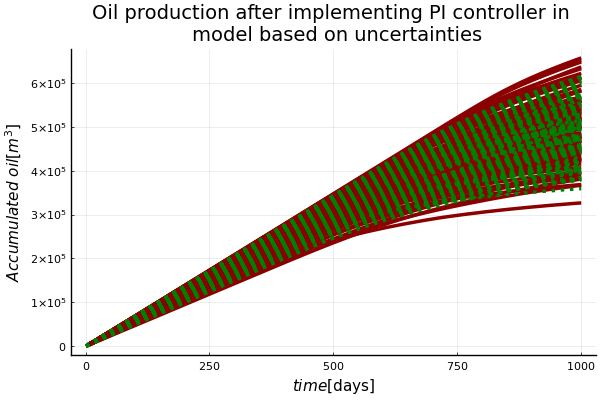

In [122]:
plot(Acc_qo_monte[:,:],lc=LCoil,lw=LW1, legend = false,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ oil[m^3]",title = "Oil production after implementing PI controller in \n model based on uncertainties")
plot!(Acc_qo_PI_monte[:,:],lc=:green,lw=LW1, legend = false, ls=:dot)
    
figfile="AccumulatedoilMonteCarlo_PIvsOpen_CF.svg"
savefig(figpath*figfile)

In [139]:
findmax(Acc_qw_PI_monte[1001,:])

(440947.03045895376, 30)

In [140]:
findmax(Acc_qw_monte[1001,:])

(473510.12703169393, 34)

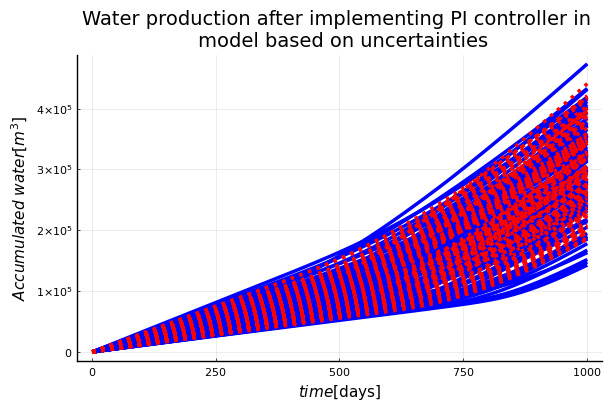

In [117]:
plot(Acc_qw_monte[:,:],lc=LCwater,lw=LW1, legend = false,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ water[m^3]",title = "Water production after implementing PI controller in \n model based on uncertainties")
plot!(Acc_qw_PI_monte[:,:],lc=:red,lw=LW1, legend = false, ls=:dot)
figfile="AccumulatedwaterMonteCarlo_PIvsOpen_CF.svg"
savefig(figpath*figfile)

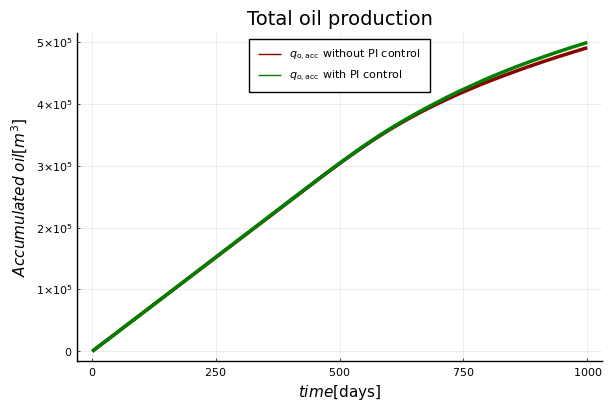

In [96]:
plot(Acc_qo[1:tim],lc=LCoil,lw=LW1,
    label = L"q_{\mathrm{o,acc}}\ \mathrm{without\ PI\ control}",xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ oil[m^3]",legend = :top,title = "Total oil production")
plot!(Accoil_PI[1:tim],lc=:green,lw=LW1,
    label = L"q_{\mathrm{o,acc}}\ \mathrm{with\ PI\ control}",
    legend = :top,title = "Total oil production")

figfile="AccumulatedOil_PIvsOpen_CF.svg"
savefig(figpath*figfile)

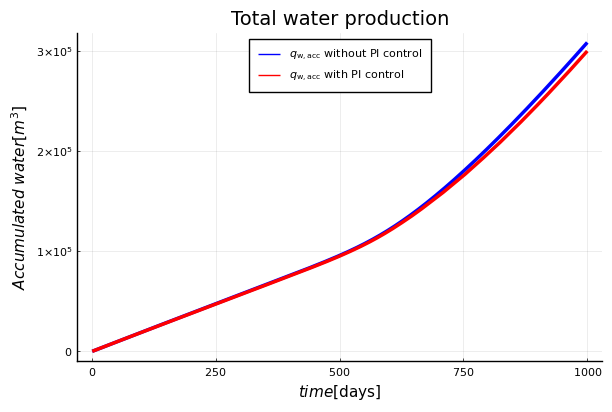

In [102]:
plot(Acc_qw[1:tim],lc=LCwater,lw=LW1,
    label = L"q_{\mathrm{w,acc}}\ \mathrm{without\ PI\ control}",xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ water[m^3]",legend = :top,title = "Total water production")
plot!(Accwater_PI[1:tim],lc=:red,lw=LW1,
    label = L"q_{\mathrm{w,acc}}\ \mathrm{with\ PI\ control}",
    legend = :top,title = "Total water production")

figfile="Accumulatedwater_PIvsOpen_CF.svg"
savefig(figpath*figfile)

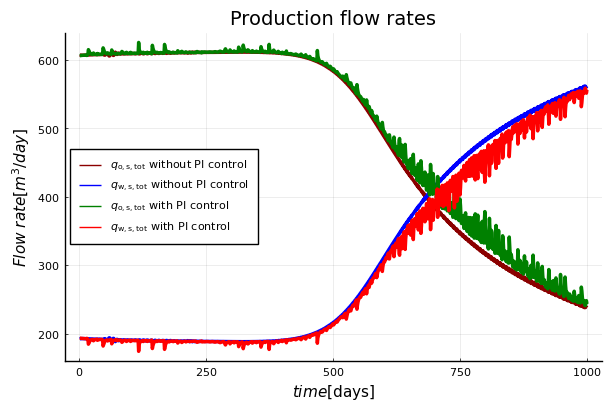

In [129]:
plot(summat_qo[1:tim]*3600*24, lc=LCoil,
    lw=LW1, label = L"q_{\mathrm{o,s,tot}}\ \mathrm{without\ PI\ control}",
    xlabel = L"time[\mathrm{days}]",legend = :left,
    ylabel = L"Flow\ rate[m^3/day]",title = "Production flow rates")
plot!(summat_qw[1:tim]*3600*24, lc=LCwater,lw=LW1,label = L"q_{\mathrm{w,s,tot}}\ \mathrm{without\ PI\ control}")

plot!(OilFlow_PI[1:tim]*3600*24, lc=:green,lw=LW1,label = L"q_{\mathrm{o,s,tot}}\ \mathrm{with\ PI\ control}")
plot!(WaterFlow_PI[1:tim]*3600*24, lc=:red,lw=LW1,label = L"q_{\mathrm{w,s,tot}}\ \mathrm{with\ PI\ control}")

figfile="Flowrates_PIvsOpen_CF.svg"
savefig(figpath*figfile)

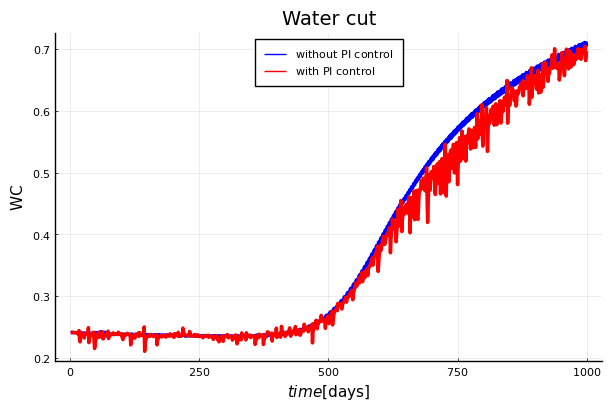

In [116]:
plot([1:tim],q_wcut_[10,:],lc=LCwater,
    lw=LW1,label = L"\mathrm{without\ PI\ control}",legend =:topleft,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"\mathrm{WC}", title = "Water cut")

plot!( Watercut_PI[1:tim],lc=:red,lw=LW1,
    label = L"\mathrm{with\ PI\ control}",
    legend = :top,title = "Water cut")
figfile="watercut_PIvsOpen_CF.svg"
savefig(figpath*figfile)

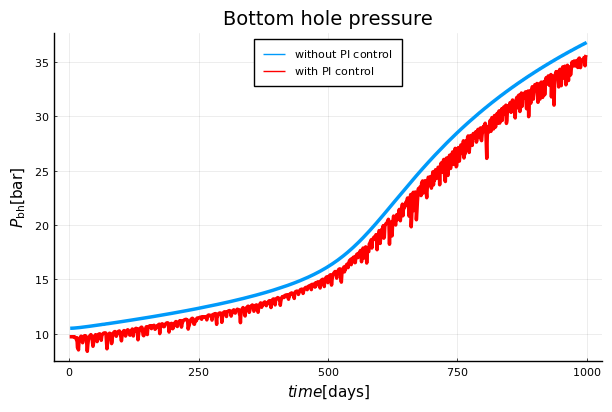

In [113]:
plot([2:tim],pb_[2:tim]/1e5,lw=LW1,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"P_\mathrm{\mathrm{bh}}[\mathrm{bar}]",label = L"\mathrm{without\ PI\ control}",legend =:topleft,
    title = "Bottom hole pressure")
plot!( Bottomhole_PI[2:tim]/1e5,lc=:red,lw=LW1,
    label = L"\mathrm{with\ PI\ control}",
    legend = :top)
figfile="bottomholepressure_PIvsOpen_CF.svg"
savefig(figpath*figfile)